In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

import graphviz
from sklearn import tree
import pydotplus

warnings.filterwarnings("ignore")

In [2]:
color_list = ['rgb(215,25,28)','rgb(253,174,97)','rgb(171,217,233)','rgb(44,123,182)']
cerc_color = ['rgb(1, 47, 83)']

In [3]:
account = pd.read_csv("./dados/account.asc", sep=';', dtype={'account_id':str, 'district_id_branch':str})
account['account_creation_YYMMDD'] = pd.to_datetime(account['account_creation_YYMMDD'], format='%y%m%d')

district = pd.read_csv("./dados/district.asc", sep=';', dtype={'district_id':str})

loan = pd.read_csv("./dados/loan.asc", sep=';', dtype={'loan_id':str, 'account_id':str})
loan['loan_granted_YYMMDD'] = pd.to_datetime(loan['loan_granted_YYMMDD'], format='%y%m%d') 

transaction = pd.read_csv("./dados/trans.asc", sep=';', dtype={'trans_id':str, 'account_id':str, 'transaction':str, 'operation':str,
                                                               'description':str, 'bank_of_partner':str, 'account_of_partner':str})
transaction['transaction_date_YYMMDD'] = pd.to_datetime(transaction['transaction_date_YYMMDD'], format='%y%m%d') 

# Perfil da base de clientes

## Evolução da carteira de clientes entre 1993 e 1997

In [4]:
qtd_contas = account.nunique()['account_id']
qtd_distritos = account.nunique()['district_id_branch']
ano_final = account.account_creation_YYMMDD.max().strftime('%Y')
print(f"A base possui {qtd_contas} contas em {qtd_distritos} distritos ao final de {ano_final}")

A base possui 4500 contas em 77 distritos ao final de 1997


In [28]:
monthly_growth = account.groupby(pd.Grouper(key='account_creation_YYMMDD', freq='M'))[['account_id']].count().cumsum()
fig = px.line(monthly_growth, y='account_id', title='Crescimento mensal da base de clientes', color_discrete_sequence=color_list[::-1])
fig.update_layout(template='plotly_white', xaxis_title='Data', yaxis_title='Total de contas')
fig.update_layout(font_size=16, font_color="black")

In [6]:
anual_growth = account.groupby(pd.Grouper(key='account_creation_YYMMDD', freq='Y'))[['account_id']].count().cumsum()
print(f"A base de clientes cresceu em média {round(anual_growth.pct_change()['account_id'].mean()*100)}% ao ano")

A base de clientes cresceu em média 42% ao ano


## Localização dos clientes

In [30]:
contas_e_distritos = account.merge(district, left_on='district_id_branch', right_on='district_id')
contas_por_distrito = (contas_e_distritos.groupby("district_name").count().sort_values('account_id', ascending=False)/len(account)).head(10)
contas_por_distrito['account_id'] *= 100
fig = px.bar(contas_por_distrito, y='account_id', title='Top 10 distritos com mais contas', color_discrete_sequence=color_list[::-1])
fig.update_layout(template='plotly_white', xaxis_title='Distrito', yaxis_title='% do total')
fig.update_layout(font_size=12, font_color="black")

- 554 contas (12% do total) estão em Praga, Capital da República Tcheca. Possivelmente onde fica a matriz da empresa.

## Perfil de movimentações dos clientes

In [8]:
monthly_transaction_by_client = transaction.groupby([pd.Grouper(key='transaction_date_YYMMDD', freq='M'), 'account_id']).sum().reset_index()
monthly_transaction_by_client = monthly_transaction_by_client.groupby(pd.Grouper(key='transaction_date_YYMMDD', freq='M'))[['amount']].mean()
print(f"A média de movimentação mensal por cliente é de ${round(monthly_transaction_by_client['amount'].mean())},00")

A média de movimentação mensal por cliente é de $32091,00


In [32]:
transaction_type = transaction.replace(
    {
        'CREDIT':'Crédito', 
        'WITHDRAWAL':'Débito', 
        'WITHDRAWAL_IN_CASH':'Saque'
    }).copy()

monthly_transaction_by_client = transaction_type.groupby([pd.Grouper(key='transaction_date_YYMMDD', freq='M'), 'account_id', 'transaction']).sum().reset_index()
monthly_transaction_by_client = monthly_transaction_by_client.groupby([pd.Grouper(key='transaction_date_YYMMDD', freq='M'), 'transaction'])[['amount']].mean().reset_index()

fig = px.line(monthly_transaction_by_client, x='transaction_date_YYMMDD', y='amount', color='transaction', title='Média de movimentação mensal por cliente', color_discrete_sequence=color_list[::-1])
fig.update_layout(
    template='plotly_white', xaxis_title='Data da movimentação', yaxis_title='Volume médio transacionado por cliente',
    shapes=[
        dict(
          type= 'line',
          yref= 'y', y0= monthly_transaction_by_client['amount'].mean(), 
            y1= monthly_transaction_by_client['amount'].mean(),
          xref= 'paper', x0= 0, x1= 1
        )
])
fig.update_layout(font_size=13, font_color="black")

In [10]:
mean_monthly_transaction_by_client = monthly_transaction_by_client.groupby("transaction").mean()
coroa_tcheca = .24
CREDIT = round(mean_monthly_transaction_by_client.loc["Crédito", 'amount']*coroa_tcheca)
WITHDRAWAL = round(mean_monthly_transaction_by_client.loc["Débito", 'amount']*coroa_tcheca)
WITHDRAWAL_IN_CASH = round(mean_monthly_transaction_by_client.loc["Saque", 'amount']*coroa_tcheca)
print(f"Caso a moeda utilizada seja a Coroa Tcheca, os clientes deste banco transacionam em média: \nBRL {CREDIT},00 em crédito \
\nBRL {WITHDRAWAL},00 em débito \nBRL {WITHDRAWAL_IN_CASH},00 em saques\n")
print(f"A conversão utilizada foi de {coroa_tcheca} reais por Coroa Tcheca (em 21/11/2020)")

Caso a moeda utilizada seja a Coroa Tcheca, os clientes deste banco transacionam em média: 
BRL 4089,00 em crédito 
BRL 4000,00 em débito 
BRL 3837,00 em saques

A conversão utilizada foi de 0.24 reais por Coroa Tcheca (em 21/11/2020)


<a id='sugestao1'></a>
## Campanhas para aquisição de clientes

In [11]:
perfil_cidades = (
    pd.DataFrame(
        district[['n_inhabitants', 'ratio_urban_inhabitants', 'n_cities','average_salary','n_enterpreneurs_per_1000_inhabitants']]
        .mean(), 
        columns=['Média geral']
    )
)
perfil_cidades_contas = (
    pd.DataFrame(
        contas_e_distritos[['n_inhabitants', 'ratio_urban_inhabitants', 'n_cities','average_salary','n_enterpreneurs_per_1000_inhabitants']]
        .mean(), 
        columns=['Média contas']))
comparativo_perfil_cidades = perfil_cidades.merge(perfil_cidades_contas, left_index=True, right_index=True)

In [12]:
contas_hab = contas_e_distritos.groupby("district_name").agg({'account_id':'count', 'n_inhabitants':'mean'})
contas_hab['contas por habitantes'] = contas_hab['account_id']/contas_hab['n_inhabitants']

campanha = contas_e_distritos.groupby("district_name").agg({"average_salary":"mean", "n_inhabitants":"mean", "account_id":"count"})
campanha['contas por habitantes'] = campanha['account_id']/campanha['n_inhabitants']
campanha.query("average_salary>{} and n_inhabitants>{} and `contas por habitantes`<{}".format(
    comparativo_perfil_cidades.loc['average_salary', 'Média geral'],
    comparativo_perfil_cidades.loc['n_inhabitants', 'Média geral'],
    contas_hab['contas por habitantes'].mean()
))

,average_salary,n_inhabitants,account_id,contas por habitantes
district_name,,,,
Brno - mesto,9897,387570,128,0.000330
Ceske Budejovice,10045,177686,41,0.000231
Frydek - Mistek,9893,228848,83,0.000363
Hl.m. Praha,12541,1204953,554,0.000460
Hradec Kralove,9425,161854,49,0.000303
Kladno,9753,149893,48,0.000320
Liberec,9198,159617,57,0.000357
Ostrava - mesto,10673,323870,135,0.000417
Pardubice,9538,162580,53,0.000326


In [13]:
campanha.query("average_salary>{} and n_inhabitants>{} and `contas por habitantes`<{}".format(
    comparativo_perfil_cidades.loc['average_salary', 'Média geral'],
    comparativo_perfil_cidades.loc['n_inhabitants', 'Média geral'],
    contas_hab['contas por habitantes'].mean()
)).to_csv("campanha_aquisicao_clientes.csv")

- Poderiam ser feitas campanhas de marketing nos distritos acima para aumentar a carteira de clientes. 
- Estes distritos possuem salário médio e número de habitantes acima da média e quantidade de contas por habitantes do distrito abaixo da média, ou seja, são cidades grandes, bem desenvolvidas e com baixa penetração de mercado
- Isto ajudaria a aumentar a receita da empresa

# Empréstimos

In [14]:
print(f"{round(loan['account_id'].nunique()/len(account)*100, 2)}% das contas pegaram empréstimos.")

15.16% das contas pegaram empréstimos.


In [39]:
loan_status = loan.replace(
    {
        'CONTRACT_FINISHED_LOAN_NOT_PAYED':'Finalizado e não pago',
        'CONTRACT_FINISHED_NO_PROBLEMS':'Finalizado com sucesso', 
        'ACTIVE_CONTRACT_NO_PROBLEMS': 'Ativo em dia',
        'ACTIVE_CONTRACT_IN_DEBT': 'Ativo em atraso'
    }
)
fig = px.bar(loan_status.groupby("status").count(), y='loan_id', title='Empréstimos realizados por status', color_discrete_sequence=color_list[::-1])
fig.update_layout(template='plotly_white', xaxis_title='Status do contrato', yaxis_title='Quantidade de empréstimos')
fig.update_layout(font_size=16, font_color="black")

In [16]:
loan_by_status = loan.groupby("status")[['loan_id']].count()
total = ['CONTRACT_FINISHED_NO_PROBLEMS', 'CONTRACT_FINISHED_LOAN_NOT_PAYED']
default = 'CONTRACT_FINISHED_LOAN_NOT_PAYED'
PD_finished = round(loan_by_status.loc[default, 'loan_id']/loan_by_status.loc[total, 'loan_id'].sum()*100, 1)
print("Dos contratos já finalizados, {}% deles não foram pagos ".format(PD_finished))

total = ['ACTIVE_CONTRACT_IN_DEBT', 'ACTIVE_CONTRACT_NO_PROBLEMS']
default = 'ACTIVE_CONTRACT_IN_DEBT'
PD_active = round(loan_by_status.loc[default, 'loan_id']/loan_by_status.loc[total, 'loan_id'].sum()*100, 1)
print("Dos contratos ainda em aberto, {}% estão em atraso. ".format(PD_active))

Dos contratos já finalizados, 13.2% deles não foram pagos 
Dos contratos ainda em aberto, 10.0% estão em atraso. 


## Taxa de inadimplência por duração dos empréstimos

In [41]:
total = ['CONTRACT_FINISHED_NO_PROBLEMS', 'CONTRACT_FINISHED_LOAN_NOT_PAYED']
default_finished = 'CONTRACT_FINISHED_LOAN_NOT_PAYED'
PD_by_duration = loan.groupby(["durationMONTHS", 'status'])[['loan_id']].count()
finished = PD_by_duration[PD_by_duration.index.isin(total, level=1)]
finished['%'] = finished['loan_id']/finished.groupby("durationMONTHS").sum()['loan_id']

total = ['ACTIVE_CONTRACT_IN_DEBT', 'ACTIVE_CONTRACT_NO_PROBLEMS']
default_active = 'ACTIVE_CONTRACT_IN_DEBT'
PD_by_duration = loan.groupby(["durationMONTHS", 'status'])[['loan_id']].count()
active = PD_by_duration[PD_by_duration.index.isin(total, level=1)]
active['%'] = active['loan_id']/active.groupby("durationMONTHS").sum()['loan_id']

pd_duracao = active[active.index.isin([default_active], level=1)].reset_index()
pd_duracao = pd_duracao.append(finished[finished.index.isin([default_finished], level=1)].reset_index())
pd_duracao['%'] *= 100
pd_duracao = pd_duracao.replace({
    'ACTIVE_CONTRACT_IN_DEBT':'Ativo',
    'CONTRACT_FINISHED_LOAN_NOT_PAYED':'Finalizado'
}
)

fig = px.line(pd_duracao, x='durationMONTHS', y='%', color='status',hover_data=['loan_id'],
       title='A Taxa de inadimplência aumenta juntamente com a duração do empréstimo', color_discrete_sequence=color_list[::-1])
fig.update_layout(template='plotly_white', xaxis_title='Duração do empréstimo', yaxis_title='Taxa de inadimplência (%)')
fig.update_layout(font_size=16, font_color="black")

## Taxa de inadimplência por valor dos empréstimos

In [71]:
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

In [75]:
total = ['CONTRACT_FINISHED_NO_PROBLEMS', 'CONTRACT_FINISHED_LOAN_NOT_PAYED']
default_finished = 'CONTRACT_FINISHED_LOAN_NOT_PAYED'

loan['amount_qcut'] =  pd.qcut(loan['amount'], 6)

PD_by_value = loan.groupby(["amount_qcut", 'status'])[['loan_id']].count()
finished = PD_by_value[PD_by_value.index.isin(total, level=1)]
finished['%'] = finished['loan_id']/finished.groupby("amount_qcut").sum()['loan_id']

total = ['ACTIVE_CONTRACT_IN_DEBT', 'ACTIVE_CONTRACT_NO_PROBLEMS']
default_active = 'ACTIVE_CONTRACT_IN_DEBT'

#loan.loc[loan.status.isin(total), 'amount_qcut'] =  pd.qcut(loan.loc[loan.status.isin(total), 'amount'], 5)

PD_by_value = loan.groupby(["amount_qcut", 'status'])[['loan_id']].count()
active = PD_by_value[PD_by_value.index.isin(total, level=1)]
active['%'] = active['loan_id']/active.groupby("amount_qcut").sum()['loan_id']

In [97]:
pd_valor = active[active.index.isin([default_active], level=1)].reset_index()
pd_valor = pd_valor.append(finished[finished.index.isin([default_finished], level=1)].reset_index())
pd_valor['%'] *= 100
pd_valor = pd_valor.replace({
    'ACTIVE_CONTRACT_IN_DEBT':'Ativo',
    'CONTRACT_FINISHED_LOAN_NOT_PAYED':'Finalizado'
}
)
pd_valor['amount_qcut_r'] = "de &#36;"+pd_valor['amount_qcut'].apply(lambda x: human_format(x.left)).astype(str)+' a &#36;'+pd_valor['amount_qcut'].apply(lambda x: human_format(x.right)).astype(str)

fig = px.line(pd_valor.astype({'amount_qcut':str}), x='amount_qcut_r', y='%', color='status',hover_data=['loan_id'],
       title='A probabilidade de default é maior para empréstimos de maior valor', color_discrete_sequence=color_list[::-1])
fig.update_layout(template='plotly_white', xaxis_title='Faixa de valor do empréstimo ($)', yaxis_title='Taxa de inadimplência (%)')
fig.update_layout(font_size=14, font_color="black")

<a id='sugestao2'></a>
## Redução do número de parcelas e valor dos empréstimos

- A taxa de inadimplência é maior para empréstimos de maior valor e com mais parcelas. Uma primeira melhoria na concessão de crédito seria realizar empréstimos de valores menores e mais curtos.

# Modelagem

- Utilizando um modelo de machine learning para entender as causas de inadimplências e tentar prever as próximas inadimplências
- A variável resposta utilizada foi o atraso ou não pagamento dos contratos de empréstimos

In [20]:
# Preenchendo o valor faltante de taxa de desemprego e número de crimes cometidos faltantes
district_tmp = district.drop(68).astype({'unemploymant_rate_95':float, 'n_commited_crimes_95':float})
district.loc[district['unemploymant_rate_95']=='?', 'unemploymant_rate_95'] = (
    district.loc[district['unemploymant_rate_95']=='?', 'unemploymant_rate_96']/
    (district_tmp.unemploymant_rate_96/district_tmp.unemploymant_rate_95).mean()
)

district.loc[district['n_commited_crimes_95']=='?', 'n_commited_crimes_95'] = (
    district.loc[district['n_commited_crimes_95']=='?', 'n_of_commited_crimes_96']/
    (district_tmp.n_of_commited_crimes_96/district_tmp.n_commited_crimes_95).mean()
)

district = district.astype({'unemploymant_rate_95':float, 'n_commited_crimes_95':float})

# Resumo de transações por cliente
transaction_summary = transaction.groupby('account_id').agg({
    "trans_id":"count", 
    'amount':['sum', 'mean', 'std'],
    'balance_after_transaction':['mean', 'std'],
})

transaction_summary.columns = ['Qtd de transacoes', 'total_transacionado', 'valor medio de transacoes', 'desvio padrão de valores',
                       'médias de saldo em conta', 'desvio padrão de saldo em conta']
transaction_summary = transaction_summary.reset_index()
#transaction_summary['coef variacao saldo'] = transaction_summary['desvio de saldo em conta']/transaction_summary['médias de saldo em conta']

# Resumo mensal de transações por cliente

def mean_pct_change(series):
    return series.pct_change().mean()

monthly_transaction_summary = transaction.groupby(['account_id',pd.Grouper(key='transaction_date_YYMMDD', freq='M')]).agg({
    'trans_id':'count',
    'amount':'sum',
    'balance_after_transaction':'mean'
}).reset_index()
monthly_transaction_summary = monthly_transaction_summary.groupby("account_id").agg({
    "trans_id":'mean',
    'amount':'mean', 
    'balance_after_transaction':['mean', mean_pct_change, 'std']
})

monthly_transaction_summary.columns = ['media de transacoes', 'media de volume mensal', 'media de saldo mensal', 'media de aumento percentual de saldo',
                                       'desvio padrao do saldo mensal']
monthly_transaction_summary['coef variacao mensal saldo'] = monthly_transaction_summary['desvio padrao do saldo mensal']/monthly_transaction_summary['media de saldo mensal']

# Resumo mensal de transações por tipo de transação por cliente

monthly_transaction_by_type_summary = (
    transaction
    .groupby(
        ['account_id',
         pd.Grouper(key='transaction_date_YYMMDD', freq='M'),
         'transaction'
        ]
    )
    .agg({
        'trans_id':'count',
        'amount':'sum',
        'balance_after_transaction':'mean'
    })
    .reset_index()
    .pivot(
        index = ['account_id', 'transaction_date_YYMMDD'], 
        columns='transaction',
        values=['trans_id','amount']
    )
    .fillna(0)
)
monthly_transaction_by_type_summary.columns = [x[0]+'_'+x[1] for x in list(monthly_transaction_by_type_summary)]

monthly_transaction_by_type_summary = monthly_transaction_by_type_summary.groupby("account_id").mean().reset_index()

df_full = account.copy()
df_full = df_full.merge(district, left_on='district_id_branch', right_on='district_id')
df_full = df_full.merge(loan, on='account_id')
df_full['dias ate emprestimo'] = (df_full['loan_granted_YYMMDD']-df_full['account_creation_YYMMDD']).dt.days
df_full = df_full.merge(transaction_summary, on='account_id')
df_full = df_full.merge(monthly_transaction_summary, on='account_id')
df_full = df_full.merge(monthly_transaction_by_type_summary, on='account_id')

In [21]:
data_use = (
    df_full
    .drop([
        'account_id','district_id_branch',  'account_creation_YYMMDD', 
        'district_id', 'loan_id', 'loan_granted_YYMMDD'], 
        axis=1
    )
    .replace({
        'CONTRACT_FINISHED_NO_PROBLEMS':0, 
        'ACTIVE_CONTRACT_NO_PROBLEMS':0,
        'ACTIVE_CONTRACT_IN_DEBT':1, 
        'CONTRACT_FINISHED_LOAN_NOT_PAYED':1
    })
    .rename(
        columns={"amount_WITHDRAWAL_IN_CASH":"Volume médio de saques",
                "trans_id_WITHDRAWAL_IN_CASH": "Quantidade de operações de saque", 
                 "trans_id_CREDIT": "Quantidade de operações de depósito"}
    )
)

X = pd.get_dummies(data_use.drop(['status'], axis=1)).to_numpy()
y = data_use['status'].to_numpy()

## Validação cruzada

- Métrica:  F1 balanceada
    - Métrica bastante utilizada para bases desbalanceadas (Como é o caso desta base)
    - Combinação entre recall e precision
    - $F1 = {{2*precision*recall}\over{precision+recall}}$
    - Média ponderada por cada classe

In [22]:
n_splits = 5
clf = DecisionTreeClassifier(random_state=137, min_samples_leaf=int(len(X)*0.03))

cv = ShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=137)

scores = cross_val_score(clf, X, y, cv=cv, scoring='f1_weighted')
print(f"{n_splits} validações cruzadas\n")
print(f"F1 balanceado: \nMédia: {round(np.mean(scores), 3)} \nDesvio Padrão:{round(np.std(scores), 3)}")

clf = clf.fit(X, y)

5 validações cruzadas

F1 balanceado: 
Média: 0.921 
Desvio Padrão:0.013


<a id='sugestao3'></a>
## Árvore de decisão

- Árvores de decisão são fáceis de analisar o output

In [23]:
blue = []
red = []
sb_colors_cmap = []
for r, g, b in zip(np.linspace(255, 215, 100), np.linspace(255, 25, 100), np.linspace(255, 28, 100)):
    red.append([r, g, b])
    
for r, g, b in zip(np.linspace(255,44, 100), np.linspace(255, 123, 100), np.linspace(255, 182, 100)):
    blue.append([r, g, b])

colors = [blue, red]

In [24]:


dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=list(pd.get_dummies(data_use.drop(['status'], axis=1))),  
                      class_names=['Bom', 'Mau'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
nodes = graph.get_node_list()

for node in nodes:
    if node.get_name() not in ('node', 'edge'):
        values = clf.tree_.value[int(node.get_name())][0]
        scale_color = colors[np.argmax(values)]
        rgb_color = scale_color[int(abs(values[0]-values[1])/max(values)*100)-1]
        node.set_fillcolor("#{0:02x}{1:02x}{2:02x}".format(int(rgb_color[0]), int(rgb_color[1]), int(rgb_color[2])))

graph.write_png("./imgs/DecisionTree.png")

True

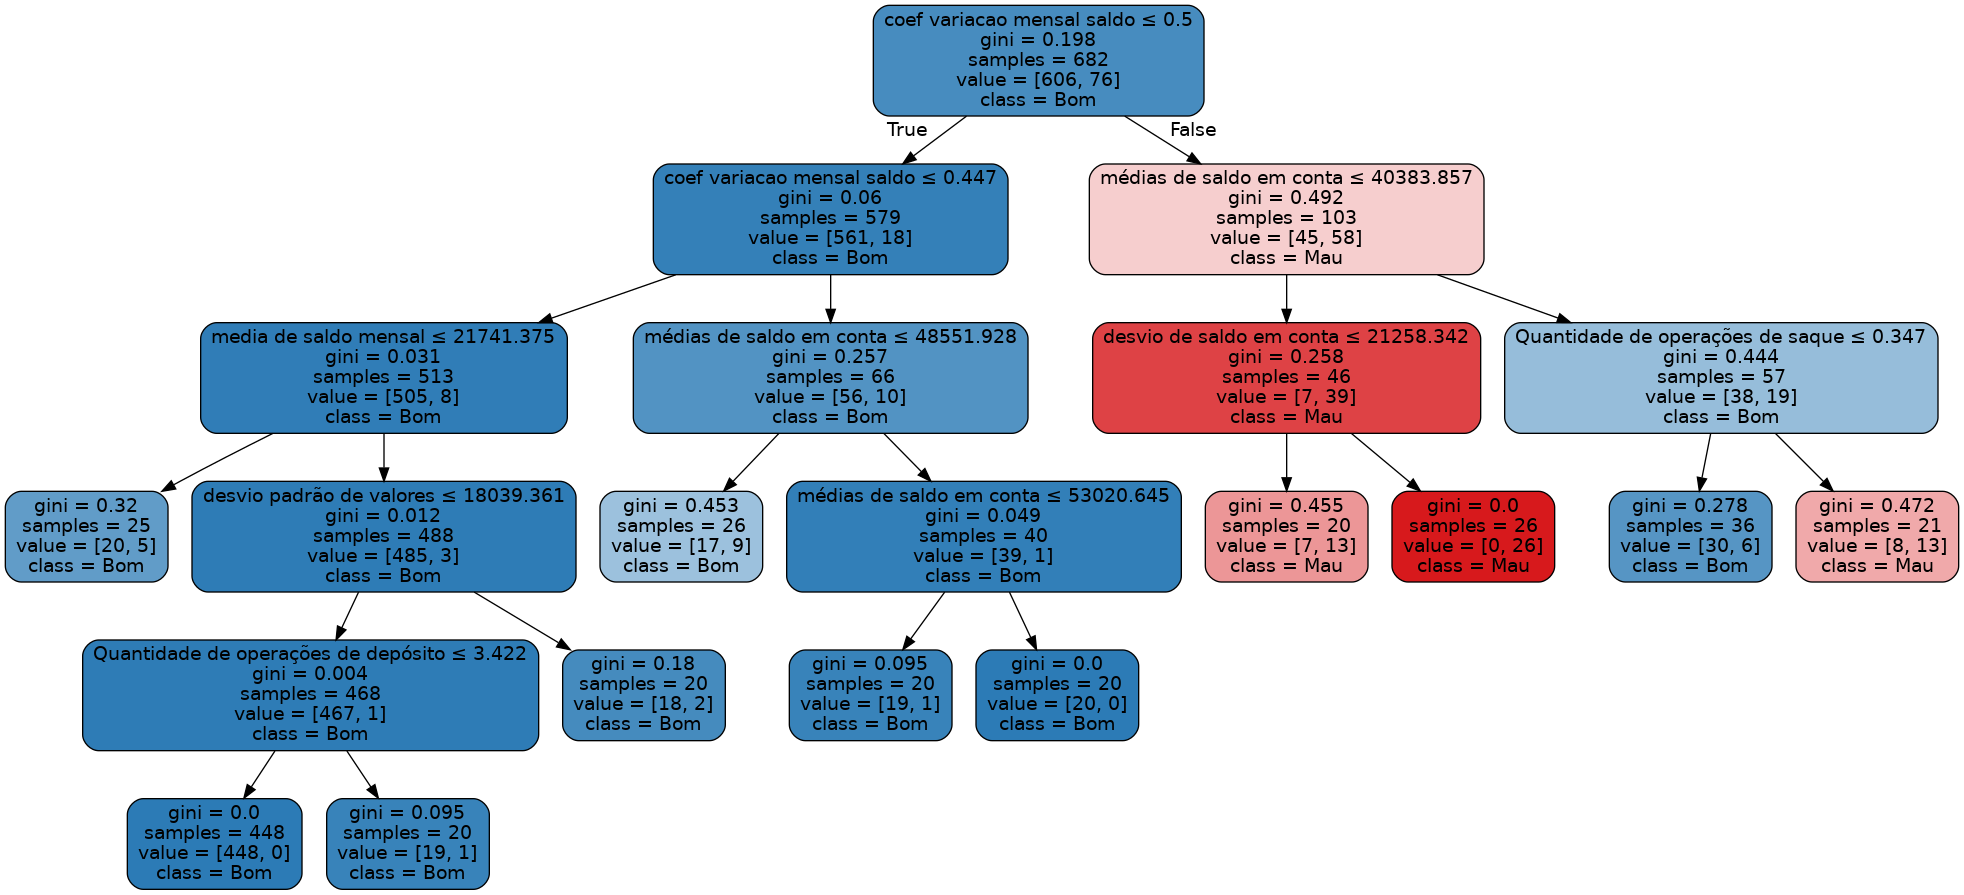

## Importância das variáveis e explicabilidade do modelo

In [25]:
pd.DataFrame({'Feature':list(pd.get_dummies(data_use.drop(['status'], axis=1))),
              'Importance':clf.feature_importances_}).sort_values("Importance", ascending=False).query("Importance>0")


,Feature,Importance
28,coef variacao mensal saldo,0.654879
21,médias de saldo em conta,0.212672
31,Quantidade de operações de saque,0.068814
22,desvio padrão de saldo em conta,0.035108
25,media de saldo mensal,0.022657
20,desvio padrão de valores,0.004657
29,Quantidade de operações de depósito,0.001213


- A árvore de decisão mostra que o coeficiente de variação (Desvio padrão/Média) do saldo mensal é a variável mais relevante para prever o pagamento dos empréstimos. Isto quer dizer que clientes que não possuem estabilidade financeira são mais propensos a não honrar com suas dívidas.
- O saldo médio em conta também é bem relevante para prever se o cliente irá pagar o empréstimo. Clientes com menores saldo em conta também são mais propensos a não pagar os empréstimos.

# Conclusão

Para aumentar a receita do banco, propõe-se três mudanças:
- [Campanhas para aumentar a carteira de clientes](#sugestao1)
    - Aumentar a quantidade de clientes irá aumentar a receita do banco
    - As cidades selecionadas são as melhores escolhas para iniciar uma campanha de marketing
- [Créditos de menor valor e de curta duração](#sugestao2)
    - Os créditos concedidos com menor valor e menor duração possuem uma taxa de inadimplência menor
    - Pode-se criar uma linha de crédito com esse perfil
- [Análise de comportamento para a concessão de crédito](#sugestao3)
    - O comportamento de transação dos clientes se mostrou extremamente relevante para prever a inadimplência dos clientes
    - A estabilidade financeira e o saldo em conta são essenciais para avaliar a concessão de crédito

[Link da apresentação](https://docs.google.com/presentation/d/1nI4v4fxdGX1b87rd0RbQ6dd428AFi4OP5pHKWsYMvJA/edit?usp=sharing)